The notebook dives into the steps required for creating / porting a model into the transformers library.

The process is discussed https://huggingface.co/docs/transformers/en/add_new_model

In [9]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset

from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoConfig,
    Trainer,
    TrainingArguments
)

from huggingface_hub import notebook_login

In [6]:
notebook_login()

In [7]:
# create the dataset
from sklearn import datasets

X, y = datasets.make_regression(n_samples=100, n_features=5, n_targets=1, noise=12, random_state=123)

In [11]:
class RegSet(Dataset):
    
    def __init__(self, x, y):
        super(RegSet,self).__init__()
        self.x = torch.from_numpy(x.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.y = self.y.view(-1, 1)
        self.samples = self.x.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.samples
    

regset = RegSet(X,y)

In [13]:
# testing the indexing 
print(regset[0])

# testing the length
print(len(regset))

(tensor([-2.7986,  0.9275, -0.6999, -1.7715, -0.2556]), tensor([-254.4539]))
100


In [38]:
# building the model

class TransformerLinear(nn.Module):
    def __init__(self, in_feats, out_feats, hidden_feats):
        super(TransformerLinear, self).__init__()
        self.lin1 = nn.Linear(in_feats, hidden_feats)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(hidden_feats, out_feats)
        
    def forward(self, x):
        out = self.lin1(x)
        out = self.relu(out)
        out = self.lin2(out)
        return out

In [15]:
# creating Dataloader and testing the batches

dloader = DataLoader(dataset=regset, batch_size=4)

test_iter = iter(dloader)

next(test_iter)

[tensor([[-2.7986,  0.9275, -0.6999, -1.7715, -0.2556],
         [ 0.8961,  0.0036, -0.7613,  0.3696,  1.6122],
         [ 0.7539,  0.3226,  0.0688, -0.2468, -1.6004],
         [ 1.6981, -0.4564, -1.0848, -0.6885, -1.3804]]),
 tensor([[-254.4539],
         [ 130.6255],
         [-145.6720],
         [-267.8007]])]

In [39]:
num_epochs = 1
learning_rate = 0.01

regmodel = TransformerLinear(5, 1, 10)

criteria = nn.MSELoss()
optimizer = optim.SGD(regmodel.parameters(),lr=learning_rate)

In [33]:
regset[0][1]

tensor([-254.4539])

In [45]:
pred_test = regmodel(regset[99][0])
pred_test

tensor([-0.0695], grad_fn=<ViewBackward0>)

In [46]:
criteria(pred_test, regset[99][1])

tensor(20455.4062, grad_fn=<MseLossBackward0>)

In [49]:
for epoch in range(num_epochs): # iterate on epochs
    for ind, batch in enumerate(dloader):  # iterate on dataloader
        pred = regmodel(batch[0])
        loss = criteria(pred, batch[1])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Batch: {ind} completed")
        
    print(f"Completing epoch: {epoch} with loss of {loss.item()}")

Batch: 0 completed
Batch: 1 completed
Batch: 2 completed
Batch: 3 completed
Batch: 4 completed
Batch: 5 completed
Batch: 6 completed
Batch: 7 completed
Batch: 8 completed
Batch: 9 completed
Batch: 10 completed
Batch: 11 completed
Batch: 12 completed
Batch: 13 completed
Batch: 14 completed
Batch: 15 completed
Batch: 16 completed
Batch: 17 completed
Batch: 18 completed
Batch: 19 completed
Batch: 20 completed
Batch: 21 completed
Batch: 22 completed
Batch: 23 completed
Batch: 24 completed
Completing epoch: 0 with loss of nan


### Adding model to Transformers Library

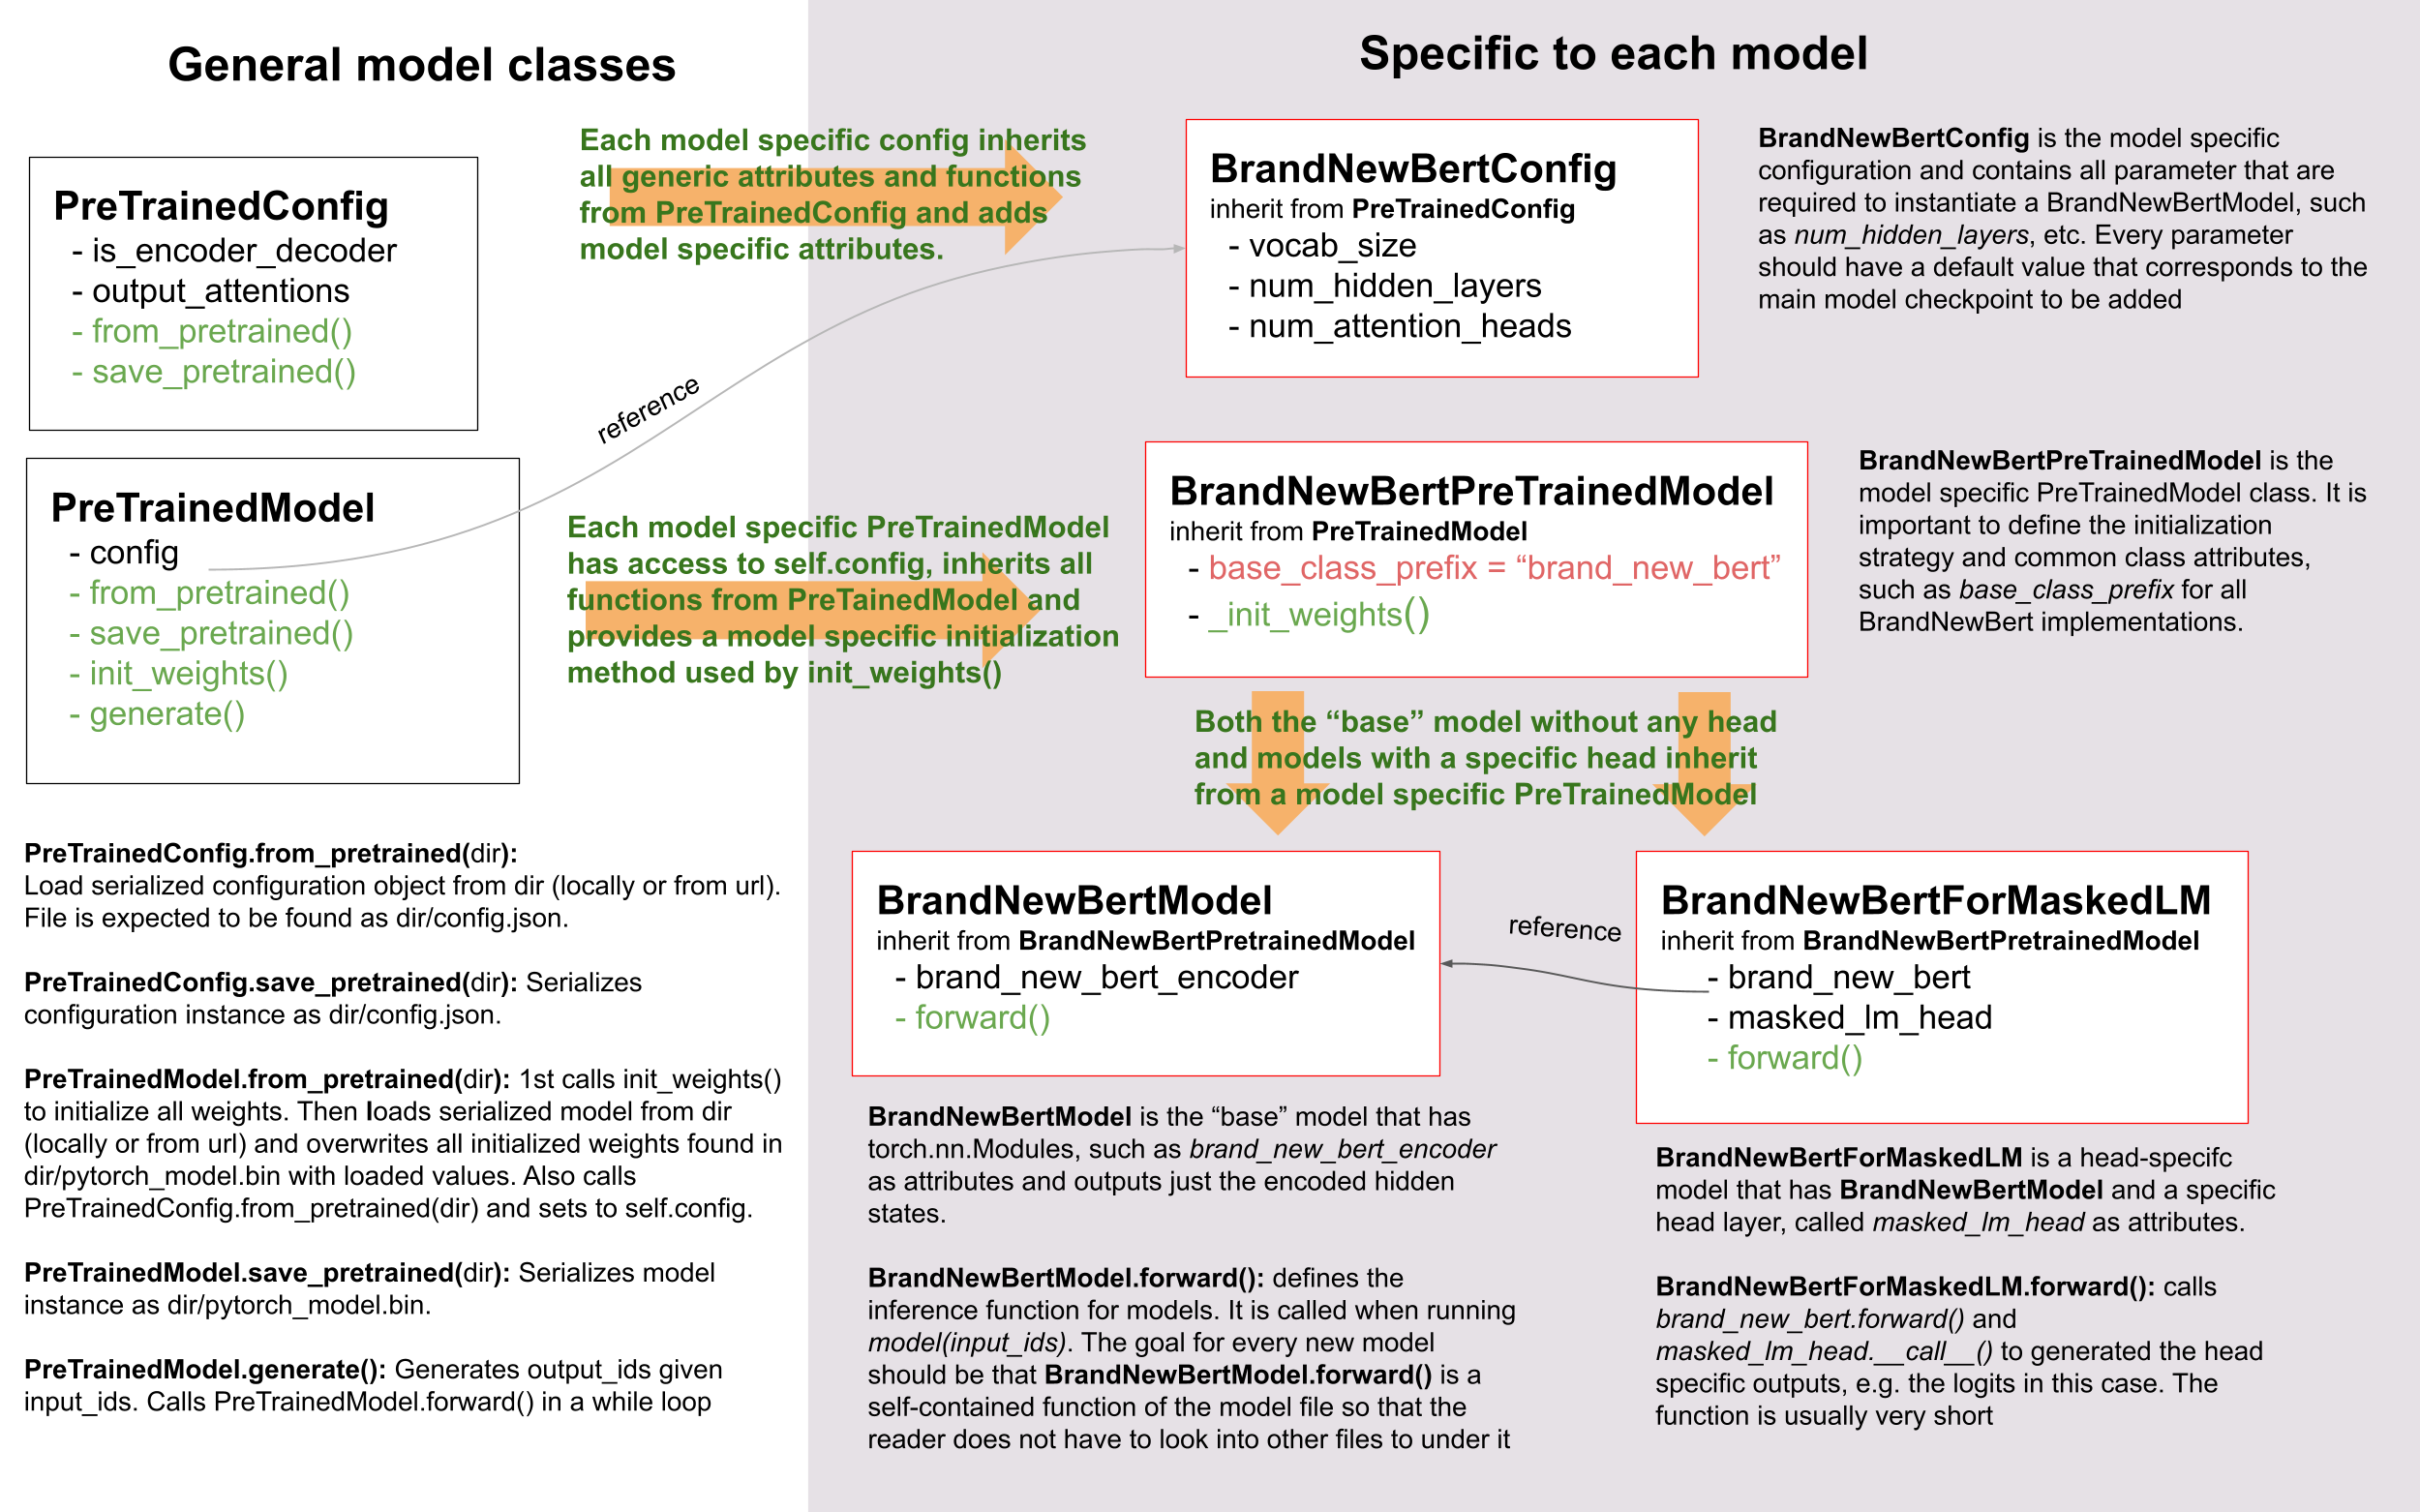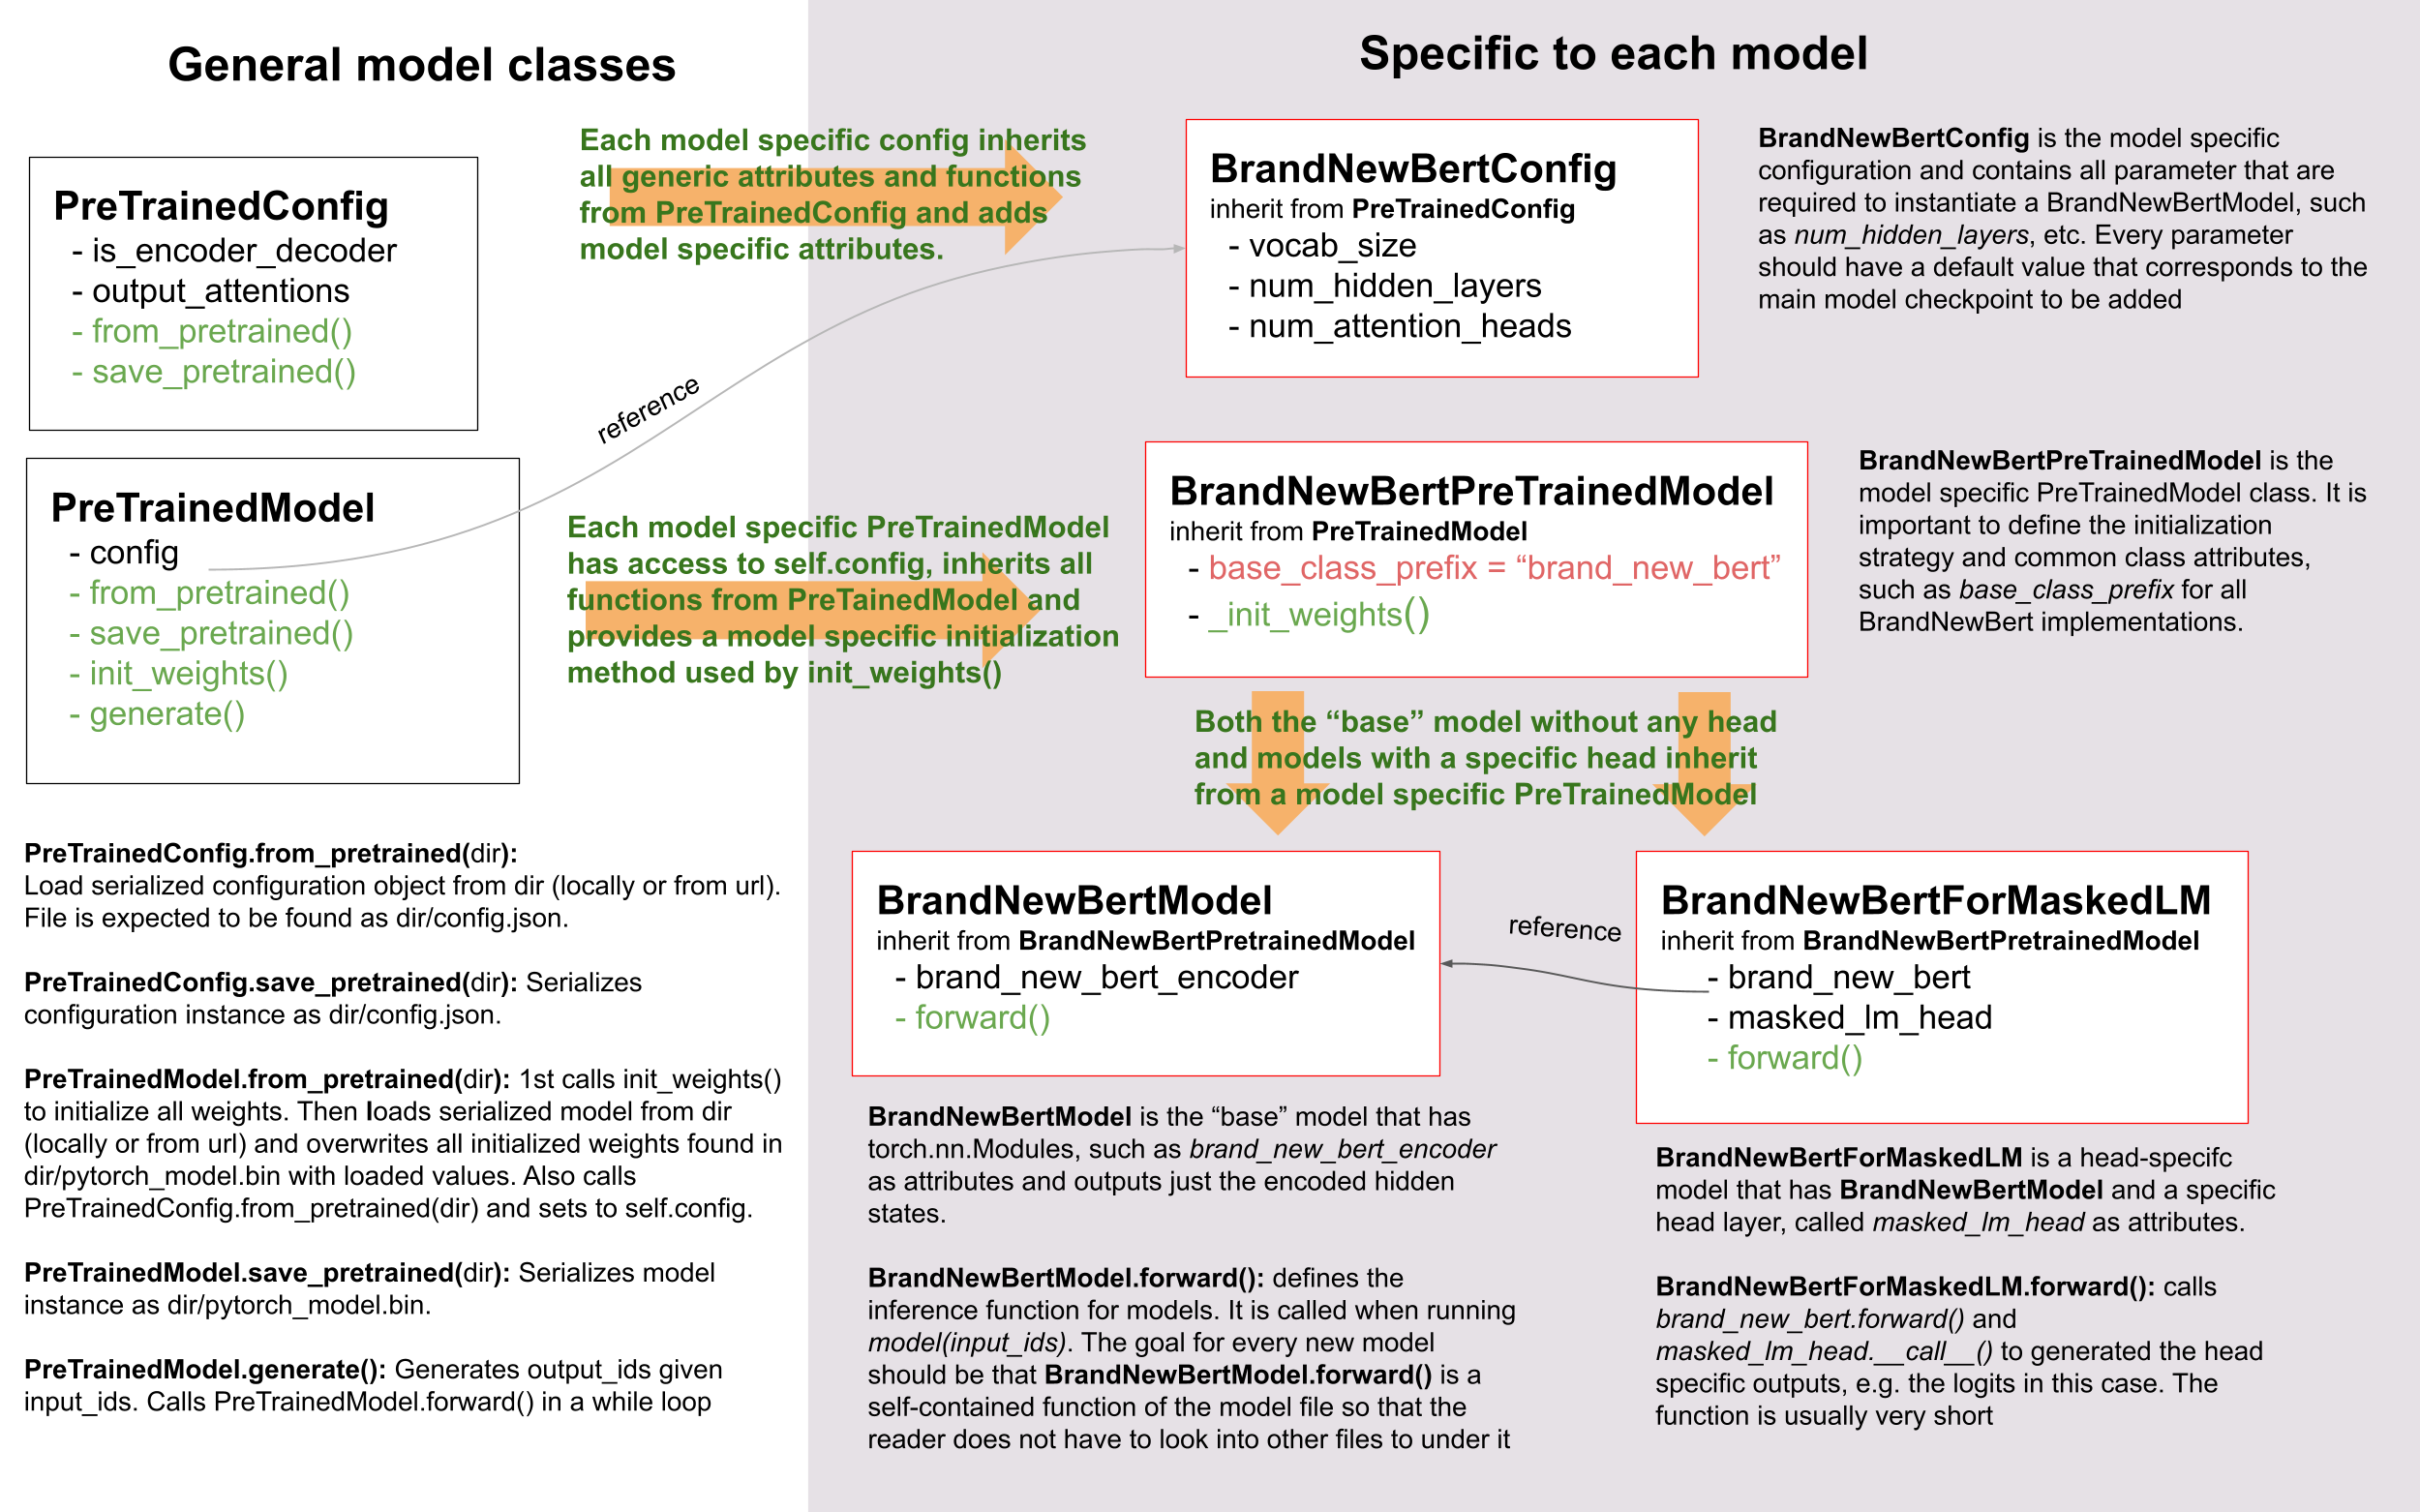

> There are never more than two levels of abstraction for any model in the library. TransformerLinearModel inherits from TransformerLinearPreTrainedModel which in turn inherits from PreTrainedModel and that’s it.

> The important functionalities that are automatically provided to every new model are from_pretrained() and save_pretrained(), which are used for serialization and deserialization

> Important functionalities, such as BrandNewBertModel.forward should be completely defined in the new modeling_brand_new_bert.py script.

>  Every new model requires a configuration class, called TransformerLinearConfig. The configuration inherits basic serialization and deserialization functionalities from PretrainedConfig.

>  Note that it might very well happen that your model’s tokenizer is based on one model implementation, and your model’s modeling code on another one. E.g. FSMT’s modeling code is based on BART, while FSMT’s tokenizer code is based on XLM.

